In [ ]:
%matplotlib inline
from fastai.basics import *

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [3]:
path = Config().data_path()/'mnist'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/mnist')

In [ ]:
!mv '/content/gdrive/My Drive/fastai-v3/mnist.pkl.gz' '/root/.fastai/data/mnist'

바로 업로드하려니 너무 오래 걸려서 다운받은 파일을 구글 드라이브에 업로드한 다음 path로 옮겼다.

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/mnist/mnist.pkl.gz')]

In [ ]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

다운받은 pickle을 통해 train, validation, test set이 만들어졌다. 위 코드를 보면 test set 자리에는 언더바가 있는데, 이것은 그냥 내가 해당 set은 신경 안쓰겠다는 의미이다. 즉, 우리가 쓸건 앞의 두 set이다.

In [7]:
x_train[0]

array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32)

In [8]:
len(x_train)

50000

In [9]:
len(x_train[0])

784

총 50000개 데이터가 있는 x_train에서 x_train의 첫번째가 어떻게 생겼는지 봤는데, 당연히 직관적으로는 의미를 모르고 그냥 784개의 float들만 나열되어있다. 과연 이것이 무엇을 의미하는지는 아래처럼 reshape하면서 알아낼 수 있다.

In [10]:
y_train[0]

5

reshape하기 전에 그에 대응하는 y_train[0]이 무엇인지 살펴봤더니 아무래도 5를 뜻하는 듯 하다. 그러므로 아래에서 시험삼아 reshape한 것은 5처럼 보여야 한다.

(50000, 784)

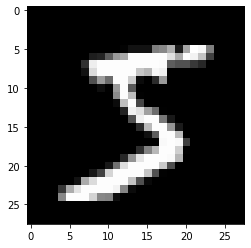

In [11]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

실제로도 5가 나왔다.

여기를 좀더 설명하자면, 우리의 set은 원래 50000행 784열 형태를 가지고 있다. 그리고 여기서 784란 사실 28x28 픽셀을 의미한다(그러니까 윗 셀의 결과로 나온 784개 수는 아마도 rgb의 평균을 의미하겠지? 그것을 흑백조로 지금 프린트 한 것이다). 그래서 x_train의 첫번째 것을 28x28의 이미지로 바꿔놓으면 위처럼 5의 형태를 띄는 모양이 만들어지는 것을 볼 수 있다. 

In [12]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
n, c, x_train.shape, y_train.min(), y_train.max()

(50000, 784, torch.Size([50000, 784]), tensor(0), tensor(9))

지금 데이터들은 numpy array이다. 이것들을 tensor로 변형해준다.

x_train.shape의 값을 보았듯이, n은 총 개수고, c는 열이다. 그리고 마지막줄에서 당연히 숫자는 0~9이니 최소는 0, 최대는 9이다.

아래에서 보여지듯 tensor로 변형되었다.

In [13]:
x_train[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [14]:
y_train[0]

tensor(5)

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [ ]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

bias로 인한 극단성을 막기 위해 1의 colulmn을 넣어주는 과정이 필요한데 과거에 우리는 이걸 위의 코멘트에 보이는 것처럼 직접 넣어줬다. 그런데 이걸 PyTorch의 TensorDataset이 알아서 하게 해줄 수 있다. DataBunch.create를 통해 Batchsize 64로 다음 데이터들을 불러오게 하는 일종의 data loader를 만들었다.

In [16]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

data를 확인해보니 64(bs)x784(pixel)로 잘 load되는 것을 알 수 있다.

In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

이제 nn.Module의 상속 클래스 Mnist_Logistic을 만든다. 반드시 생성자를 재정의해줘야 한다. 일단 이 클래스로 현재 batch에 대한 ax+b를 반환한다고 이해하면 된다.

In [ ]:
model = Mnist_Logistic().cuda()

GPU에 weight matric을 수동으로 주기 위해 .cuda()를 추가한다.

In [19]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [20]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [21]:
model(x).shape

torch.Size([64, 10])

In [22]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

여기까지 model이 잘 만들어졌는지 확인했고, 정상적으로 model.lin이 만들어진 것을 알 수 있다.

In [ ]:
lr=2e-2

In [ ]:
loss_func = nn.CrossEntropyLoss()

loss_func은 CrossEntropyLoss로 해준다. MSE를 안쓰는 이유는 4를 3으로 예측했다고 "거의 가깝게 예측했다!" 이런게 아니기 때문이다.

In [ ]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

이부분은 lessong 2 SGD랑 비슷한데, 차이점은 더이상 a@x가 아니라 model을 부른다는 것이다. 

In [ ]:
losses = [update(x,y,lr) for x,y in data.train_dl]

정의한 update 함수를 learning rate 2e-2로 적용시켜서 그 결과들을 losses에 저장했고, 아래에 losses를 그래프로 보여주면서 loss가 갈 수록 어떻게 변했는지 보여줬다.

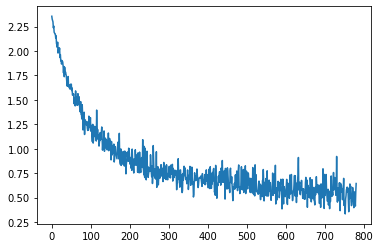

In [27]:
plt.plot(losses);

loss가 점점 내려가는 것을 볼 수 있다. 

In [ ]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

Mnist_NN 클래스를 만들어줬다. 이번에는 linear layer가 두 개이다. 첫번째것의 크기 50의 weight matrix에다가 ReLU를 계산해주고, 그것을 두번째 레이어의 input으로 넣어주는 일을 한다.

ReLU에 대한 설명

딥러닝에서는 노드에 들어오는 값들에 대해 곧바로 다음 레이어로 전달하지 않고 주로 비선형 함수를 통과시킨 후 전달하는데, 이때 사용하는 함수를 Activation Function이라 부른다. ReLU는 그 중에 하나로 이런 개형을 보인다.
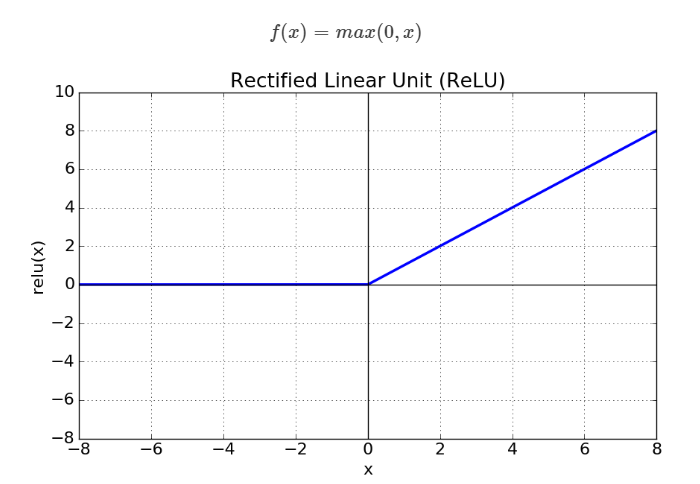



즉, x>0 이면 기울기가 1인 직선이고, x<0이면 함수값이 0이된다.

그래서 ReLU에는 다음과 같은 특징이 있다.
1. sigmoid, tanh 함수와 비교시 학습이 훨씬 빨라진다.

2. 연산 비용이 크지않고, 구현이 매우 간단하다.
3. x<0인 값들에 대해서는 기울기가 0이기 때문에 뉴런이 죽을 수 있는 단점이 존재한다.

ps)깉헙에서 코멘트에 넣는 이미지가 깨지던데, 그래프 개형은 _/ 이렇게 생겼다. 꺾이는 부분이 x=0인 지점이다.

In [ ]:
model = Mnist_NN().cuda()

In [ ]:
losses = [update(x,y,lr) for x,y in data.train_dl]

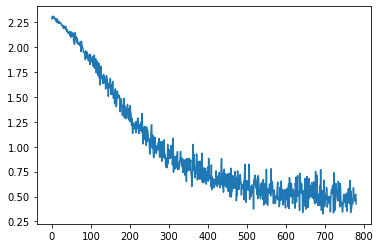

In [31]:
plt.plot(losses);

여기까지 위와 똑같은 일을 반복해주면, 이번에도 마찬가지로 점점 줄어드는 loss를 볼 수 있다.

In [ ]:
model = Mnist_NN().cuda()

In [ ]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [ ]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

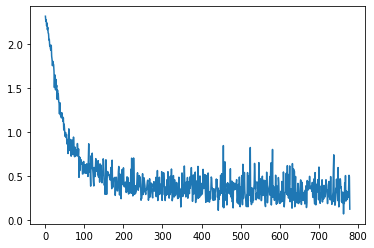

In [35]:
plt.plot(losses);

Adam은 learning rate를 가지고 있는데, 우리는 이것을 디폴트로 사용해왔다. 그런데, adam의 loss는 지금까지 우리가 봐온 그래프랑 조금 다르게 요동치는 모습을 보인다. 그 이유는 지금까지는 fastai가 평균값을 계산해줘왔기 때문에 깨끗한 그래프로 그려진 것이다.

In [ ]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [37]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


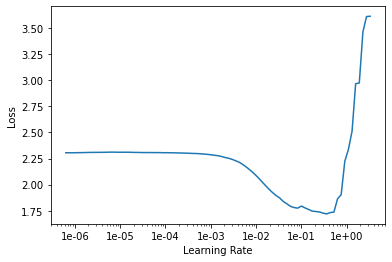

In [38]:
learn.lr_find()
learn.recorder.plot()

learning rate에 따른 loss를 보여준다.

In [39]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.141858,0.133283,0.961900,00:03


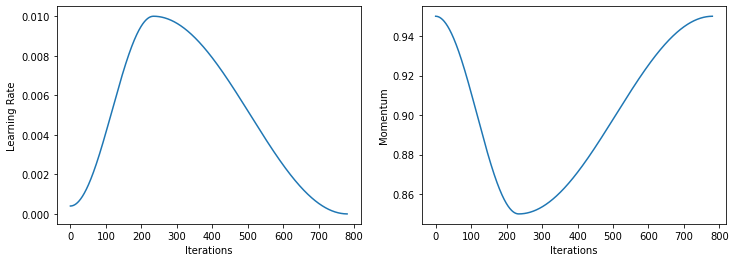

In [40]:
learn.recorder.plot_lr(show_moms=True)

위 코드 실행 결과에서 알 수 있듯이 Learning Rate와 Momentum이 반비례하는 모습을 볼 수 있다. 

**Q. 강의자분이 왜 이런 일이 일어나는지 설명해주시긴 했는데 영어가 짧아서 이해가 안간다...
(Every time our learning rate is small, our momentum is high. Why is that? Because I do have a learning small learning rate, but you keep going in the same direction, you may as well go faster. But if you're jumping really far, don't like jump really far because it's going to throw you off. Then as you get to the end again, you're fine tuning in but actually if you keep going the same direction again and again, go faster.) 
위 두 그래프가 말하는 바가 무엇일까?**

어쨌든 저 두 결과의 결합이 바로 우리가 지금까지 써온 cycle의 의미이다.

*네 https://github.com/hiromis/notes/blob/master/Lesson5.md 수업 노트 다시 읽어 보시면 아마 도움이 될 듯. *

*learning rate와 momentum 추가 설명 : https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/*

*SGD with momentum 얘기 : https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d*

*링크 보시고 질문이 더 있으면 말씀해 주세요*

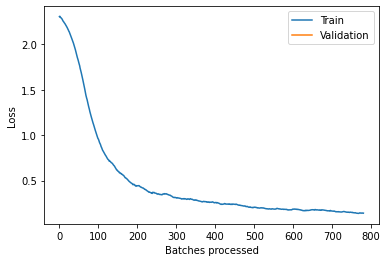

In [41]:
learn.recorder.plot_losses()

## fin